In [1]:
import pandas as pd
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import numpy as np
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler

In [2]:
df = pd.read_parquet("../data/static_models/pump3_power_siso.par")
df = df.set_index("time")
df = df.rolling(window=40, center=True).median().dropna()
df = df.resample("1min").mean().dropna()

In [3]:
df['pump3_speed'] = df['pump3_speed'].apply(lambda x: max(0, x))


In [5]:
from statsmodels.tsa.stattools import acf


In [6]:
autocorr_values = acf(df['pump3_power'], nlags=10)

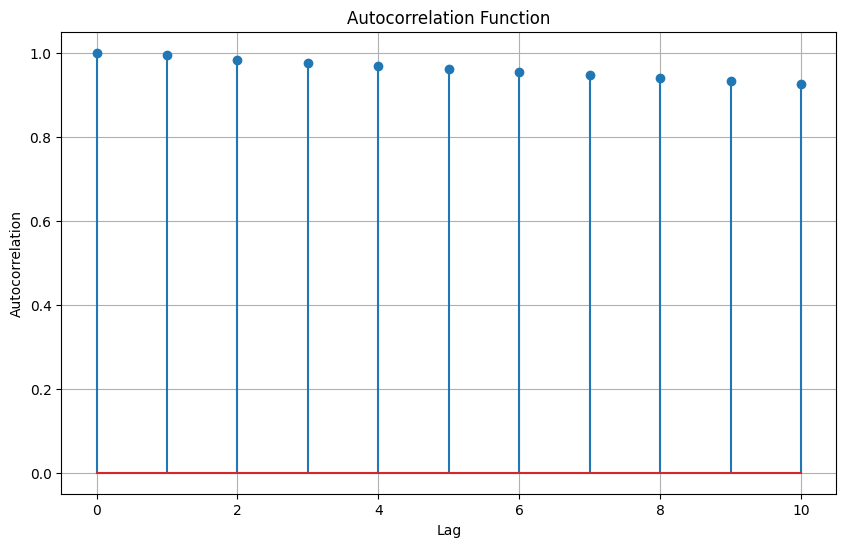

In [9]:
plt.figure(figsize=(10, 6))
plt.stem(range(10 + 1), autocorr_values)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.grid(True)
plt.show()

In [4]:
train_df = df["2024-01-09 10:30:00":"2024-01-09 16:10:00"]
test_df = df["2024-01-10":"2024-02-16 12:00:00"]

In [7]:
from src.system_identification import ARXParametersIdentification
from src.preprocessing import Preprocessor
import pandas as pd
from sysidentpy.basis_function._basis_function import Polynomial

In [8]:
FEATURES = "pump3_speed"
TARGET = 'pump3_power'

sys_id = ARXParametersIdentification(FEATURES, 
                            TARGET, 
                            dataframe= train_df, 
                            model_type= 'siso')

In [9]:
parameters = {
    'estimator': 'ridge_regression',
    'ridge_param': 2e5,
    'order_selection': False,
    'n_terms': 3,
    'extended_least_squares': False,
    'ylag': 2,  
    'xlag': 1, 
    'basis_function': Polynomial(degree=1)
}
    
fitted_model, model_parameters = sys_id.identify_arx_parameters(x_train=train_df[FEATURES], 
                                                                y_train= train_df[TARGET],
                                                                **parameters)
    
model_parameters

/home/alqua/Git/PumpStationMPC/sys_identification/src/sysidentpy/narmax_base.py:1034: RuntimeWarning: divide by zero encountered in divide
  x = x[1:] / aux_b
/home/alqua/Git/PumpStationMPC/sys_identification/src/sysidentpy/narmax_base.py:1034: RuntimeWarning: invalid value encountered in divide
  x = x[1:] / aux_b


,Regressors,Parameters,ERR
0,x1(k-1),4.1224E-02,9.8845E-01
1,y(k-1),4.5593E-03,NAN
2,y(k-2),-2.9051E-03,NAN


In [10]:
yhat  = sys_id.predict(x_test= test_df[FEATURES], y_test= test_df[TARGET], n_steps_ahead= 200)

#val_plots = sys_id.residuals_analysis(yhat, df[TARGET].values)
#print(model_parameters)

RRSE: 0.1579371620484079
MSE: 12.645265788961428


In [11]:
test_df["yhat"] = yhat

sys_id.plot_features_and_target(test_df, ['yhat', 'pump3_power'])

FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> yhat <i style="color:#fc9944">~54m</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'c479ffd3-df43-434a-8789-1813b05080d3',
              'x': array([datetime.datetime(2024, 1, 10, 0, 0, tzinfo=<UTC>),
                          datetime.datetime(2024, 1, 10, 0, 1, tzinfo=<UTC>),
                          datetime.datetime(2024, 1, 10, 0, 28, tzinfo=<UTC>), ...,
                          datetime.datetime(2024, 2, 16, 9, 39, tzinfo=<UTC>),
                          datetime.datetime(2024, 2, 16, 11, 19, tzinfo=<UTC>),
                          datetime.datetime(2024, 2, 16, 11, 26, tzinfo=<UTC>)], dtype=object),
              'y': array([ 0.        ,  0.        ,  0.        , ..., 41.4978442 , 42.88116495,
                          42.11838724])},
             {'name': ('<b style="color:sandybrown">[R' ... 'style="color:#fc9944">~54m</i>'),
              'sho

In [10]:
lower_mpc_data = pd.read_parquet(("../data/sym_data/sim_data_1s_with_eff_power.parquet"))

In [12]:
lower_mpc_data_p3_power = sys_id.predict(lower_mpc_data[FEATURES], lower_mpc_data[TARGET], n_steps_ahead= 1)

RRSE: nan
MSE: nan


In [13]:
lower_mpc_data["pump3_power_eff"] = lower_mpc_data_p3_power

In [14]:
lower_mpc_data.to_parquet(("../data/sym_data/sim_data_1s_with_eff_power2.parquet"))